In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import multiprocessing

from sklearn.impute import KNNImputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import  train_test_split

In [4]:
data = pd.read_csv('../datasets/dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       866 non-null    float64
 1   sex       866 non-null    float64
 2   cp        866 non-null    float64
 3   trestbps  809 non-null    float64
 4   chol      840 non-null    float64
 5   fbs       784 non-null    float64
 6   restecg   865 non-null    float64
 7   thalach   811 non-null    float64
 8   exang     811 non-null    float64
 9   oldpeak   806 non-null    float64
 10  slope     570 non-null    float64
 11  ca        297 non-null    float64
 12  thal      413 non-null    float64
 13  label     866 non-null    int64  
 14  split     866 non-null    object 
dtypes: float64(13), int64(1), object(1)
memory usage: 101.6+ KB


In [5]:
data = data.drop_duplicates()
X = data.drop(['label'], axis=1)
y_train = data['label'].astype(int)

In [6]:
X_test = pd.read_csv('../datasets/test_dataset.csv')
X_test['split'] = 'test'
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     float64
 2   cp        50 non-null     float64
 3   trestbps  48 non-null     float64
 4   chol      46 non-null     float64
 5   fbs       43 non-null     float64
 6   restecg   49 non-null     float64
 7   thalach   50 non-null     float64
 8   exang     50 non-null     float64
 9   oldpeak   48 non-null     float64
 10  slope     38 non-null     float64
 11  ca        12 non-null     float64
 12  thal      20 non-null     float64
 13  split     50 non-null     object 
dtypes: float64(13), object(1)
memory usage: 5.6+ KB


In [7]:
X = pd.concat([X_test, X], axis=0)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 0 to 865
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       915 non-null    float64
 1   sex       915 non-null    float64
 2   cp        915 non-null    float64
 3   trestbps  856 non-null    float64
 4   chol      885 non-null    float64
 5   fbs       826 non-null    float64
 6   restecg   913 non-null    float64
 7   thalach   860 non-null    float64
 8   exang     860 non-null    float64
 9   oldpeak   853 non-null    float64
 10  slope     608 non-null    float64
 11  ca        309 non-null    float64
 12  thal      433 non-null    float64
 13  split     915 non-null    object 
dtypes: float64(13), object(1)
memory usage: 107.2+ KB


In [8]:
X_test.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
0,56.0,1.0,2.0,124.0,224.0,1.0,0.0,161.0,0.0,2.0,2.0,NaN,NaN,test
1,61.0,1.0,4.0,125.0,0.0,0.0,0.0,105.0,1.0,0.0,3.0,NaN,7.0,test
2,52.0,1.0,4.0,135.0,0.0,NaN,0.0,128.0,1.0,2.0,2.0,NaN,7.0,test
3,64.0,1.0,4.0,120.0,0.0,1.0,1.0,106.0,0.0,2.0,2.0,NaN,NaN,test
4,49.0,1.0,1.0,130.0,0.0,0.0,1.0,145.0,0.0,3.0,2.0,NaN,NaN,test


## Data preprocessing

In [9]:
# Definimos variables categóricas y numéricas
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = ['label']
    
def data_preprocessing(df, categorical_vars, numerical_vars):
    data = df.copy()
    # Eliminamos filas duplicadas
    data = data.drop_duplicates()

    # data[categorical_vars] = data[categorical_vars].astype(float).astype('Int64')
    # luego las pasamos a string, para que su valor 
    # numérico no influya en el análisis ni en las predicciones
    # data[categorical_vars + target] = data[categorical_vars + target].astype(str)
    # ca = 9 es un oulier, lo clippeamos a 3, que es el valor máximo según las especificaciones
    data['ca'] = data['ca'].replace(9.0, 3)

    # Reemplazamos 0s en chol y trestbps con NAs
    data[['trestbps', 'chol']] = data[['trestbps', 'chol']].replace(0, np.nan)

    # Rellenamos los valores numéricos no informados
    data = data.replace(pd.NA, np.nan)
    data[categorical_vars] = data[categorical_vars].replace(np.nan, -1)
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=11)
    data[numerical_vars + categorical_vars] = imputer.fit_transform(data[numerical_vars + categorical_vars])
    # data[numerical_vars] = imputer.fit_transform(data[numerical_vars])

    # Clippeamos los outliers
    for var in ['trestbps', 'chol', 'thalach', 'oldpeak']:
        tmp_data = data[var][data[var] > 0].dropna()
        data.loc[data[var].isna(), var] = np.quantile(tmp_data, 0.5)
        q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
        iqr = q3 - q1
        cut_off = iqr * 1.5
        lower, upper = q1 - cut_off, q3 + cut_off
        data.loc[data[var] > upper, var] = upper
        data.loc[data[var] < lower, var] = lower
        
    # Parseamos las variables categóricas como enteros, para eliminar los decimales
    data[categorical_vars] = data[categorical_vars].astype(float).astype('Int64')
    return data

In [10]:
X = data_preprocessing(X, categorical_vars, numerical_vars)

In [11]:
# X_test ya está dentro de X, el pre-procesado se hace todo junto
# X_test = data_preprocessing(X_test, categorical_vars, numerical_vars)

In [12]:
pd.DataFrame(X.eq(0).sum().to_dict(), index=[f"Zero values - total"])


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
Zero values - total,0,194,0,0,0,689,549,0,525,368,0,180,0,0


In [13]:
pd.DataFrame(X.isna().sum().to_dict(), index=[f"Missing values - total"])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
Missing values - total,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
X[categorical_vars] = X[categorical_vars].astype(int)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 0 to 865
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       915 non-null    float64
 1   sex       915 non-null    int64  
 2   cp        915 non-null    int64  
 3   trestbps  915 non-null    float64
 4   chol      915 non-null    float64
 5   fbs       915 non-null    int64  
 6   restecg   915 non-null    int64  
 7   thalach   915 non-null    float64
 8   exang     915 non-null    int64  
 9   oldpeak   915 non-null    float64
 10  slope     915 non-null    int64  
 11  ca        915 non-null    int64  
 12  thal      915 non-null    int64  
 13  split     915 non-null    object 
dtypes: float64(5), int64(8), object(1)
memory usage: 107.2+ KB


In [16]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,split
0,56.0,1,2,124.0,224.000000,1,0,161.0,0,2.0,2,-1,-1,test
1,61.0,1,4,125.0,255.363636,0,0,105.0,1,0.0,3,-1,7,test
2,52.0,1,4,135.0,258.181818,-1,0,128.0,1,2.0,2,-1,7,test
3,64.0,1,4,120.0,253.090909,1,1,106.0,0,2.0,2,-1,-1,test
4,49.0,1,1,130.0,228.181818,0,1,145.0,0,3.0,2,-1,-1,test


In [17]:
# Escalamos los datos numéricos para que se ajusten a una distribución normal
X[numerical_vars] = scale(X[numerical_vars])

X[numerical_vars].describe()

,age,trestbps,chol,thalach,oldpeak
count,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02
mean,3.570914e-16,2.725203e-16,1.613615e-16,-3.388910e-16,1.316494e-16
std,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00
min,-2.716360e+00,-2.478595e+00,-2.447462e+00,-2.801991e+00,-1.371364e+00
25%,-6.942689e-01,-7.030331e-01,-6.471458e-01,-6.691562e-01,-8.698826e-01
50%,5.071222e-02,-1.111792e-01,-5.836304e-02,4.178866e-02,-3.684009e-01
75%,6.892674e-01,4.806748e-01,5.530652e-01,7.527335e-01,6.345624e-01
max,2.498507e+00,2.256236e+00,2.353382e+00,2.569593e+00,2.640489e+00


In [18]:
vals = { col: [sorted(list(X[col].dropna().unique()))] for col in categorical_vars }
pd.DataFrame(vals, index=['Unique values']).transpose()

,Unique values
sex,"[0, 1]"
cp,"[1, 2, 3, 4]"
fbs,"[-1, 0, 1]"
restecg,"[-1, 0, 1, 2]"
exang,"[-1, 0, 1]"
slope,"[-1, 1, 2, 3]"
ca,"[-1, 0, 1, 2, 3]"
thal,"[-1, 3, 6, 7]"


In [19]:
# ahora aplicamos OHE a las variables categóricas
ohe = OneHotEncoder(drop= 'first', sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = ohe_fit.get_feature_names_out()

X = pd.concat((X_ohe, X[numerical_vars + ['split']].reset_index()), axis=1)
X.set_index('index')
X.drop('index', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex_1      915 non-null    float64
 1   cp_2       915 non-null    float64
 2   cp_3       915 non-null    float64
 3   cp_4       915 non-null    float64
 4   fbs_0      915 non-null    float64
 5   fbs_1      915 non-null    float64
 6   restecg_0  915 non-null    float64
 7   restecg_1  915 non-null    float64
 8   restecg_2  915 non-null    float64
 9   exang_0    915 non-null    float64
 10  exang_1    915 non-null    float64
 11  slope_1    915 non-null    float64
 12  slope_2    915 non-null    float64
 13  slope_3    915 non-null    float64
 14  ca_0       915 non-null    float64
 15  ca_1       915 non-null    float64
 16  ca_2       915 non-null    float64
 17  ca_3       915 non-null    float64
 18  thal_3     915 non-null    float64
 19  thal_6     915 non-null    float64
 20  thal_7    

In [20]:
X_train = X[X['split'] != 'test']
X_test = X[X['split'] == 'test']

X_train = X_train.drop('split', axis=1)
X_test = X_test.drop('split', axis=1)

# Dejamos el 15% de datos para validar los modelos
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, stratify=y_train)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(735, 26)
(130, 26)
(50, 26)


In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 391 to 631
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex_1      735 non-null    float64
 1   cp_2       735 non-null    float64
 2   cp_3       735 non-null    float64
 3   cp_4       735 non-null    float64
 4   fbs_0      735 non-null    float64
 5   fbs_1      735 non-null    float64
 6   restecg_0  735 non-null    float64
 7   restecg_1  735 non-null    float64
 8   restecg_2  735 non-null    float64
 9   exang_0    735 non-null    float64
 10  exang_1    735 non-null    float64
 11  slope_1    735 non-null    float64
 12  slope_2    735 non-null    float64
 13  slope_3    735 non-null    float64
 14  ca_0       735 non-null    float64
 15  ca_1       735 non-null    float64
 16  ca_2       735 non-null    float64
 17  ca_3       735 non-null    float64
 18  thal_3     735 non-null    float64
 19  thal_6     735 non-null    float64
 20  thal_7  

In [22]:
counts = y_train.value_counts()

print(counts) 

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

0    339
1    157
3    106
2    105
4     28
Name: label, dtype: int64


{0: 100.0, 1: 46.31, 3: 31.27, 2: 30.97, 4: 8.26}

In [23]:
# Como tenemos muy pocos datos de la clase 4, vamos a hacer oversampling para que esté más balanceado, 

sm = SMOTE(sampling_strategy={4: 50}, random_state = 1, k_neighbors = 7)
X, y = sm.fit_resample(X_train, y_train)

In [24]:
counts = y_train.value_counts()

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

{0: 100.0, 1: 46.31, 3: 31.27, 2: 30.97, 4: 8.26}

## XGB Classifier

In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier as XGBC # XGBoost


In [26]:
def kfold_test(model, n_splits, X, y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_score =[]
    for train_idx, val_idx in kf.split(X, y):
        x_tr, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        #model
        model.fit(x_tr,y_tr)
        score_f1 = f1_score(y_val, model.predict(x_val), average='micro')
        cv_score.append(score_f1)

    return cv_score

def grid_search(model, params, X, y, n_splits = 5, n_jobs = multiprocessing.cpu_count() - 1, scoring = 'f1_micro', fit_params = {}):
    grid = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring=scoring,
                        cv=n_splits, 
                        verbose=1,
                        n_jobs=n_jobs)
    grid.fit(X, y,  **fit_params)
    print(f'Best params : {grid.best_params_}')
    print(f'Best score: {grid.best_score_}')
    return grid

def f1_micro_metric(y, y_pred, threshold=0.5):
    #y_bin = [1. if y_pred > threshold else 0. for y_pred in y] # binarizing output
    #y_bin = (y > threshold).astype(int)
    return f1_score(y, y_pred, average='micro')
    

In [27]:
# Xgboost params
nrounds_values = [1, 2]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 10]
lambda_values = [0, 1]
alpha_values = [0, 1]

In [26]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 4)
print(scale_pos_weight)

12.107142857142858


In [33]:
model_xgb = XGBC(nthread = 20,
                  tree_method = 'hist',
                  num_parallel_tree = 25,
                  random_state = 1,
                  early_stopping_rounds=10,
                  objective='multi:softmax',
                  eval_metric = f1_micro_metric
                )

In [28]:
model_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False,
              eval_metric=<function f1_micro_metric at 0x7fb3cae2a040>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              nthread=10, num_parallel_tree=20, predictor=None, ...)>

In [34]:
params = {
# en sklearn, algunos nombres de parametros son diferences, por eso da las warnings
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
# 'nrounds': nrounds_values, 
# 'eta': eta_values, 
'n_estimators': [20],
'learning_rate': [0.1, 0.5], 
'gamma': [0.01],
'max_depth': [6, 10],
'min_child_weight': [1, 2],
'subsample': [0.85, 1],
'colsample_bytree': [1],
# num parallel tree no influye en el score, solo sirve para decirle cuantos árboles calcula en paralelo, se puede dejar fijo a 20-25
# 'num_parallel_tree': num_parallel_tree_values,
'lambda': [1],
'alpha': [0]
}

fit_params = {'eval_set': [(X_val, y_val)], 
              'scale_pos_weight': scale_pos_weight
              'verbose': True}
grid = grid_search(model_xgb, params, X_train, y_train, n_jobs = multiprocessing.cpu_count() - 1, fit_params=fit_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[11:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-mlogloss:1.54725	validation_0-f1_micro_metric:0.48462
[11:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-mlogloss:1.54369	validation_0-f1_micro_metric:0.53846
[11:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-mlogloss:1.54668	validation_0-f1_micro_metric:0.49231
[11:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "s

In [36]:

#best_config =  {'alpha': 1, 'colsample_bytree': 0.1, 'learning_rate': 0.99, 'gamma': 1, 'lambda': 1, 'max_depth': 6, 
#                'min_child_weight': 20, 'n_estimators': 300, 'subsample': 1}

best_config = grid.best_params_

model_xgb = XGBC(nthread = 20,
                  tree_method = 'hist',
                  num_parallel_tree = 25,
                  random_state = 1,
                  early_stopping_rounds=10,
                  objective='multi:softmax',
                  n_estimators = best_config['n_estimators'],
                  learning_rate = best_config['learning_rate'],
                  gamma = best_config['gamma'],
                  reg_lambda = best_config['lambda'],
                  reg_alpha = best_config['alpha'],
                  max_depth = best_config['max_depth'],
                  min_child_weight = best_config['min_child_weight'] ,
                  eval_metric = f1_micro_metric
                )

model_xgb.fit(X_train, 
              np.array(y_train), 
              eval_set=[(X_val, y_val)],          
              verbose=True)

pred_y_train = model_xgb.predict(X_train)
pred_y_val = model_xgb.predict(X_val)

print(f"F1 score (train): {f1_score(y_train, pred_y_train, average='micro')}")
print(f"F1 score (val): {f1_score(y_val, pred_y_val, average='micro')}")


[0]	validation_0-mlogloss:1.35964	validation_0-f1_micro_metric:0.47692
[1]	validation_0-mlogloss:1.31415	validation_0-f1_micro_metric:0.46923
[2]	validation_0-mlogloss:1.31375	validation_0-f1_micro_metric:0.45385
[3]	validation_0-mlogloss:1.33345	validation_0-f1_micro_metric:0.45385
[4]	validation_0-mlogloss:1.32962	validation_0-f1_micro_metric:0.47692
[5]	validation_0-mlogloss:1.34403	validation_0-f1_micro_metric:0.46923
[6]	validation_0-mlogloss:1.35317	validation_0-f1_micro_metric:0.47692
[7]	validation_0-mlogloss:1.36793	validation_0-f1_micro_metric:0.47692
[8]	validation_0-mlogloss:1.37586	validation_0-f1_micro_metric:0.47692
[9]	validation_0-mlogloss:1.40188	validation_0-f1_micro_metric:0.46923
[10]	validation_0-mlogloss:1.42220	validation_0-f1_micro_metric:0.47692
[11]	validation_0-mlogloss:1.42278	validation_0-f1_micro_metric:0.47692
[12]	validation_0-mlogloss:1.42672	validation_0-f1_micro_metric:0.47692
F1 score (train): 0.8993197278911564
F1 score (val): 0.4538461538461538


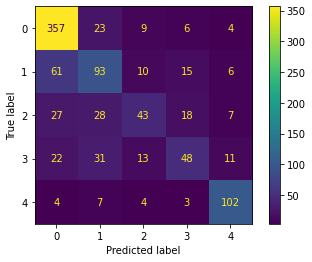

In [31]:
conf_matrix = confusion_matrix(y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_xgb.classes_)
disp.plot()

### Predicciones para el test dataset

In [43]:
pred_y_test = model_xgb.predict(X_test)
pred_df = pd.DataFrame({'ID': X_test.index.values, 'label': pred_y_test.astype(int)})
pred_df.to_csv('../submission_xgb.csv', index=False)

!head '../submission_xgb.csv'

ID,label
0,0
1,1
2,2
3,0
4,0
5,2
6,0
7,3
8,2


In [44]:
pred_df.shape

(50, 2)